## Description

Short notebook to examine which filters our events pass

In [1]:
import glob
import os
from icecube.LeptonInjector import hdf5_to_feather

import pandas as pd

from icecube import dataio, dataclasses


from collections import OrderedDict

import numpy as np

import matplotlib.pyplot as plt

try: from tqdm import tqdm
except: tqdm = lambda x: x

style_file = os.path.expandvars('$I3_SRC/LeptonInjector/python/hnl_mpl_plotstyle.mplstyle')
plt.style.use(style_file)

base_plot_dir = '/n/holylfs05/LABS/arguelles_delgado_lab/Lab/HNL_MC/plots/gen_verification'
print(base_plot_dir)

/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/jbook/i3/build/lib/icecube/LeptonInjector/__init__.py:1: UserWarning: Deprication Warning: load_pybindings() is deprecated use `from icecube._your_module import *`
  from icecube.load_pybindings import load_pybindings
/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/jbook/i3/build/lib/icecube/LeptonInjector/cascade_generator_functions.py:4: UserWarning: Using `import I3Tray` or `from I3Tray import *` is now considered depricated. Please switch to using `from icecube.icetray import I3Tray`
  from I3Tray import I3Units


/n/holylfs05/LABS/arguelles_delgado_lab/Lab/HNL_MC/plots/gen_verification


### Make fielpaths for each level

In [3]:
# define base path for this set
# sim_base_dir = '/n/holylfs05/LABS/arguelles_delgado_lab/Lab/HNL_MC/190200'
sim_base_dir = '/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/jbook/test_weighted' 

levels = [
    'Gen',
    'Phot',
    'Det',
    'L1',
    'L2',
]

# dict for infilepaths
infiles = OrderedDict(zip(levels, [list() for level in levels]))

In [4]:
# get the infilepaths
for key, item in infiles.items():
#     print(key)
    
    item.extend(
        glob.glob(os.path.join(sim_base_dir, '{}/*.hdf5'.format(key)))  # for Gen/Phot
    )
    item.extend(
        glob.glob(os.path.join(sim_base_dir, '{}/*/*/*.hdf5'.format(key)))  # for Det/L1/L2/L3/L4/L5
    )
print(infiles)

OrderedDict([('Gen', ['/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/jbook/test_weighted/Gen/test_weighting_03.hdf5']), ('Phot', ['/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/jbook/test_weighted/Phot/test_weighting_03.hdf5']), ('Det', ['/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/jbook/test_weighted/Det/test_weighting_03.hdf5']), ('L1', ['/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/jbook/test_weighted/L1/test_weighting_03.hdf5']), ('L2', ['/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/jbook/test_weighted/L2/test_weighting_03.hdf5'])])


In [5]:
level = "L2"
output_filename = f"extracted_info_{level}.npy"

# Let's just grab the first 100 files.
L2_files = sorted(glob.glob(os.path.join(sim_base_dir, level, "*.i3.zst")))[:100]

In [6]:
def get_weights(frame):
    if not frame.Has("I3MCWeightDict"):
        return False
    weight_dict = frame["I3MCWeightDict"]

    LI_weight = dataclasses.I3Double(weight_dict['LeptonInjectorWeight'])
    lifetime_weight = dataclasses.I3Double(weight_dict['LifetimeWeight_1e-03'])
    one_weight = dataclasses.I3Double(weight_dict['OneWeight'])
    reference_weight = (weight_dict['ReferenceWeight_1e-03'])

    return reference_weight


In [7]:
def get_filters(frame):
    passed_filters = []
    if not frame.Has("QFilterMask"):
        return False
    
    filter_mask_map = frame['QFilterMask']
    for filter_mask in filter_mask_map:
        name = filter_mask.key()
        filter = filter_mask.data()
            
        if filter.condition_passed:
            passed_filters.append(name)
            
    return passed_filters

In [8]:
def read_L2_frame(frame):
    passed_filters, weights = [], []
    
    if not frame.Has("QFilterMask"):
        return False
    passed_filters = get_filters(frame)
    weights = get_weights(frame)
            
    return {"passed_filters": passed_filters, "weight": weights}


In [52]:
L2_files = sorted(glob.glob(os.path.join(sim_base_dir, level, "*.i3.zst")))[:100]
nfiles = len(L2_files)
data = []
no_pass = 0
total_weights = 0
# Loop over the files
for f in tqdm(L2_files):
    i3file = dataio.I3File(f)

    # And loop through frames for this file
    while i3file.more():
        frame = i3file.pop_frame()
        vals = read_L2_frame(frame)
        if vals != False:
            data.append(vals)
            print(vals)
            total_weights += vals["weight"]
            if vals["passed_filters"] == []:
                no_pass += 1
            


  0%|          | 0/1 [00:00<?, ?it/s]

{'passed_filters': ['DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'MuonFilter_13', 'OnlineL2Filter_17'], 'weight': 7.151723112011619e-18}
{'passed_filters': ['DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'MuonFilter_13', 'OnlineL2Filter_17'], 'weight': 7.151723112011619e-18}
{'passed_filters': ['DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'MuonFilter_13', 'OnlineL2Filter_17'], 'weight': 7.151723112011619e-18}
{'passed_filters': ['DeepCoreFilter_13', 'FilterMinBias_13', 'LowUp_13'], 'weight': 1.2344236358516703e-16}
{'passed_filters': ['DeepCoreFilter_13', 'FilterMinBias_13', 'LowUp_13'], 'weight': 1.2344236358516703e-16}
{'passed_filters': ['DeepCoreFilter_13', 'FilterMinBias_13', 'LowUp_13'], 'weight': 1.2344236358516703e-16}
{'passed_filters': ['FilterMinBias_13', 'LowUp_13'], 'weight': 4.205321182816838e-21}
{'passed_filters': ['FilterMinBias_13', 'LowUp_13'], 'weight': 4.205321182816838e-21}


{'passed_filters': ['CascadeFilter_13', 'DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'GRECOOnlineFilter_19', 'LowUp_13', 'MuonFilter_13'], 'weight': 2.1248127943454113e-18}
{'passed_filters': ['CascadeFilter_13', 'FilterMinBias_13', 'LowUp_13', 'MuonFilter_13', 'VEF_13'], 'weight': 2.1414062357590725e-16}
{'passed_filters': ['CascadeFilter_13', 'FilterMinBias_13', 'LowUp_13', 'MuonFilter_13', 'VEF_13'], 'weight': 2.1414062357590725e-16}
{'passed_filters': ['CascadeFilter_13', 'FilterMinBias_13', 'LowUp_13', 'MuonFilter_13', 'VEF_13'], 'weight': 2.1414062357590725e-16}
{'passed_filters': ['DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'GRECOOnlineFilter_19', 'LowUp_13'], 'weight': 7.844247866874738e-15}
{'passed_filters': ['DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'GRECOOnlineFilter_19', 'LowUp_13'], 'weight': 7.844247866874738e-15}
{'passed_filters': ['DeepCoreFilter_13', 'FSSCandidate_13', 'F

{'passed_filters': ['DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'MonopoleFilter_16'], 'weight': 4.497420088927164e-15}
{'passed_filters': ['DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'MonopoleFilter_16'], 'weight': 4.497420088927164e-15}
{'passed_filters': ['DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'MonopoleFilter_16'], 'weight': 4.497420088927164e-15}
{'passed_filters': ['DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'GRECOOnlineFilter_19', 'LowUp_13'], 'weight': 1.0843351491218402e-14}
{'passed_filters': ['DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'GRECOOnlineFilter_19', 'LowUp_13'], 'weight': 1.0843351491218402e-14}
{'passed_filters': ['DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'GRECOOnlineFilter_19', 'LowUp_13'], 'weight': 1.0843351491218402e-14}
{'passed_filters': ['FilterMinBias_13', 'LowUp

{'passed_filters': ['FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13'], 'weight': 2.923688369864191e-22}
{'passed_filters': ['DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'LowUp_13'], 'weight': 2.1179347753977596e-13}
{'passed_filters': ['DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'LowUp_13'], 'weight': 2.1179347753977596e-13}
{'passed_filters': ['DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'LowUp_13'], 'weight': 2.1179347753977596e-13}
{'passed_filters': ['FilterMinBias_13', 'LowUp_13'], 'weight': 1.5047036664760982e-17}
{'passed_filters': ['FilterMinBias_13', 'LowUp_13'], 'weight': 1.5047036664760982e-17}
{'passed_filters': ['FilterMinBias_13', 'LowUp_13'], 'weight': 1.5047036664760982e-17}
{'passed_filters': ['CascadeFilter_13', 'DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'MuonFilter_13'], 'weight': 5.0017684235745825e-17}
{'passed_filters': ['CascadeFilte

{'passed_filters': ['DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13'], 'weight': 1.3967414545757193e-15}
{'passed_filters': ['DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'LowUp_13'], 'weight': 5.30810298907438e-15}
{'passed_filters': ['DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'LowUp_13'], 'weight': 5.30810298907438e-15}
{'passed_filters': ['DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'LowUp_13'], 'weight': 5.30810298907438e-15}
{'passed_filters': ['FilterMinBias_13', 'LowUp_13', 'MuonFilter_13'], 'weight': 7.775769239205814e-20}
{'passed_filters': ['FilterMinBias_13', 'LowUp_13', 'MuonFilter_13'], 'weight': 7.775769239205814e-20}
{'passed_filters': ['FilterMinBias_13', 'LowUp_13', 'MuonFilter_13'], 'weight': 7.775769239205814e-20}
{'passed_filters': ['DeepCoreFilter_13', 'FilterMinBias_13'], 'weight': 1.71871199749566e-14}
{'passed_filters': ['DeepCoreFilter_13', 'F

{'passed_filters': ['CascadeFilter_13', 'DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'GRECOOnlineFilter_19', 'LowUp_13', 'MuonFilter_13', 'OnlineL2Filter_17'], 'weight': 2.8727380182277603e-15}
{'passed_filters': ['CascadeFilter_13', 'FilterMinBias_13', 'LowUp_13', 'MuonFilter_13'], 'weight': 3.718146294097403e-20}
{'passed_filters': ['CascadeFilter_13', 'FilterMinBias_13', 'LowUp_13', 'MuonFilter_13'], 'weight': 3.718146294097403e-20}
{'passed_filters': ['CascadeFilter_13', 'FilterMinBias_13', 'LowUp_13', 'MuonFilter_13'], 'weight': 3.718146294097403e-20}
{'passed_filters': ['CascadeFilter_13', 'FilterMinBias_13', 'LowUp_13', 'MuonFilter_13'], 'weight': 9.175502205735588e-21}
{'passed_filters': ['CascadeFilter_13', 'FilterMinBias_13', 'LowUp_13', 'MuonFilter_13'], 'weight': 9.175502205735588e-21}
{'passed_filters': ['CascadeFilter_13', 'FilterMinBias_13', 'LowUp_13', 'MuonFilter_13'], 'weight': 9.175502205735588e-21}
{'passed_filters': ['CascadeFilter_13

100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

{'passed_filters': ['DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'GRECOOnlineFilter_19', 'LowUp_13'], 'weight': 1.2224140630628675e-13}
{'passed_filters': ['DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'GRECOOnlineFilter_19', 'LowUp_13'], 'weight': 1.2224140630628675e-13}
{'passed_filters': ['DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'GRECOOnlineFilter_19', 'LowUp_13'], 'weight': 1.2224140630628675e-13}
{'passed_filters': ['DeepCoreFilter_13', 'FilterMinBias_13'], 'weight': 2.1790243275506903e-13}
{'passed_filters': ['DeepCoreFilter_13', 'FilterMinBias_13'], 'weight': 2.1790243275506903e-13}
{'passed_filters': ['DeepCoreFilter_13', 'FilterMinBias_13'], 'weight': 2.1790243275506903e-13}
{'passed_filters': ['CascadeFilter_13', 'DeepCoreFilter_13', 'FSSCandidate_13', 'FSSFilter_13', 'FilterMinBias_13', 'LowUp_13', 'MuonFilter_13', 'OnlineL2Filter_17'], 'weight': 4.7021672313136544e-17}
{'passed_f

In [37]:
print(len(data))
print(total_weights)

5535
4.0859950278655834e-10


In [11]:
def get_filter_list(frame):
    # Returns a list of filters in QFilterMask
    names = []
    if not frame.Has("QFilterMask"):
        return False
    filter_mask_map = frame['QFilterMask']
    for filter_mask in filter_mask_map:
        name = filter_mask.key()
        names.append(name)
            
    return names

In [45]:
# Gets list of all filters from the mask, then breaks
filter_list = []
for f in tqdm(L2_files):
    i3file = dataio.I3File(f)
    # And loop through frames for this file
    while i3file.more():
        frame = i3file.pop_frame()
        filter_list = get_filter_list(frame)
        if filter_list != False:
            break

100%|██████████| 1/1 [00:00<00:00, 151.10it/s]


Text(0.5,1,'Weighted passed filters')

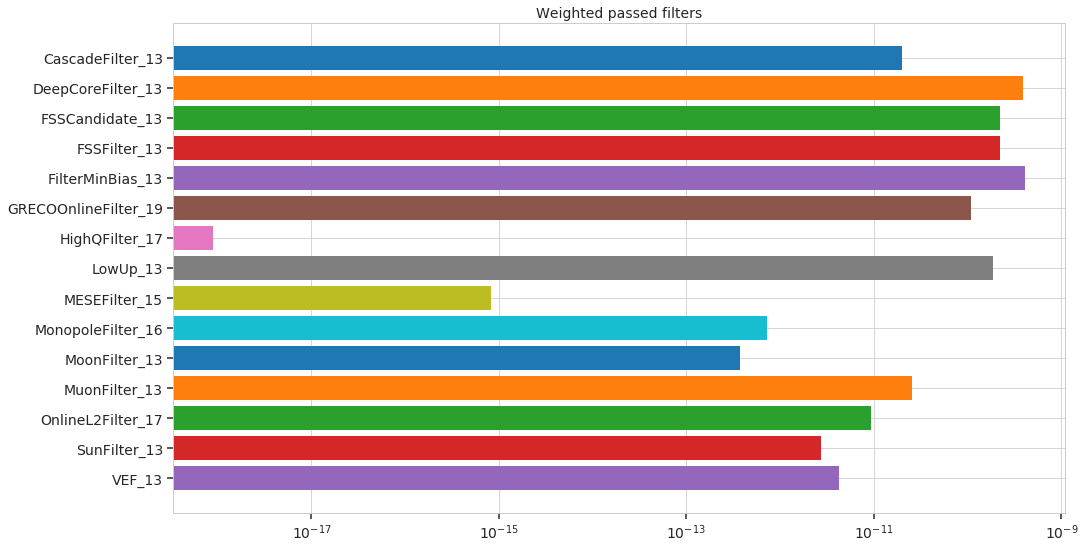

In [50]:
from matplotlib import pyplot as plt

bar_values = dict(zip(filter_list, np.zeros(len(filter_list))))
bar_values_unweighted = dict(zip(filter_list, np.zeros(len(filter_list))))

for index, weight in enumerate (df['weight']):
    for filter_name in filter_list:
        if filter_name in df['passed_filters'][index]:
            bar_values[filter_name] += float(weight)
            bar_values_unweighted[filter_name] += 1

fig, ax = plt.subplots(figsize =(16, 9))
for ic_filter in filter_list:
    if bar_values[ic_filter]!=0:
        ax.barh(ic_filter, bar_values[ic_filter])
ax.set_xscale("log")
ax.invert_yaxis()


ax.set_title("Weighted passed filters")

Text(0.5,1,'unweighted passed filters')

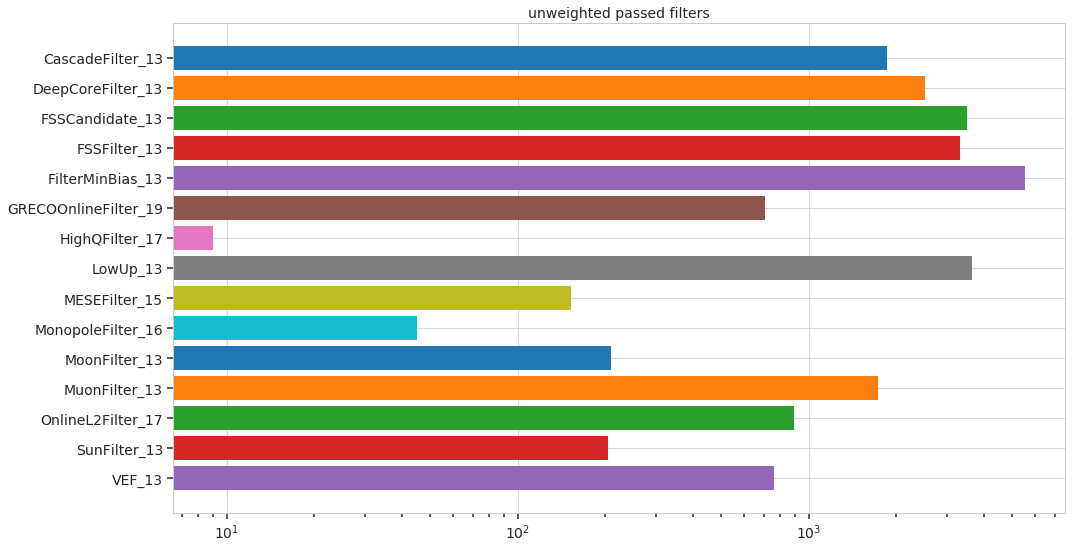

In [49]:
fig, ax = plt.subplots(figsize =(16, 9))
for ic_filter in filter_list:
    if bar_values_unweighted[ic_filter]!=0:
        ax.barh(ic_filter, bar_values_unweighted[ic_filter])
ax.set_xscale("log")
ax.invert_yaxis()
ax.set_title("unweighted passed filters")

Text(0.5,1,'Weighted filter efficiency')

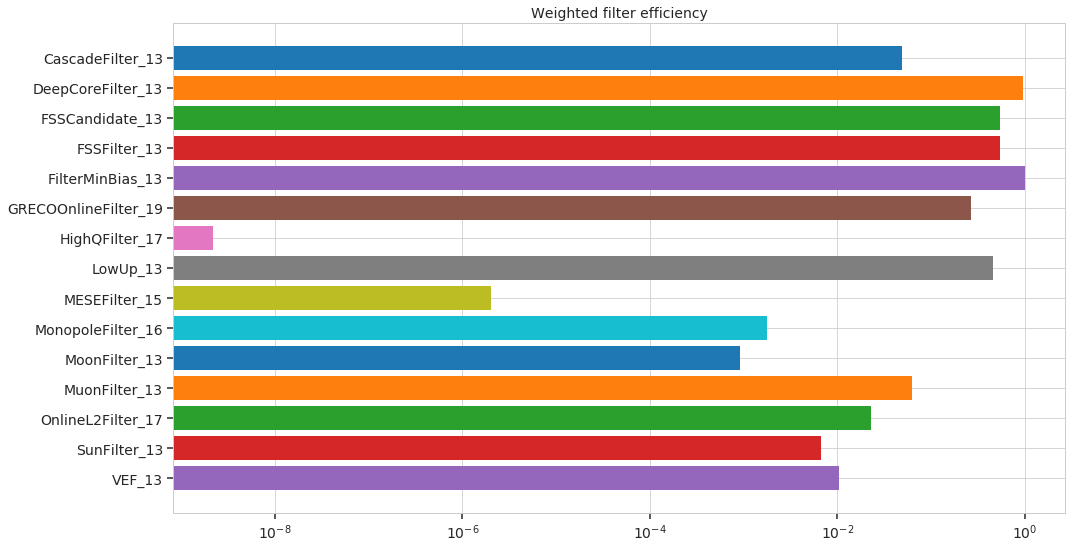

In [48]:
fig, ax = plt.subplots(figsize =(16, 9))
for ic_filter in filter_list:
    if bar_values[ic_filter]!=0:
        ax.barh(ic_filter, bar_values[ic_filter]/total_weights)
ax.set_xscale("log")
ax.invert_yaxis()
ax.set_title("Weighted filter efficiency")

Text(0.5,1,'Unweighted filter efficiency')

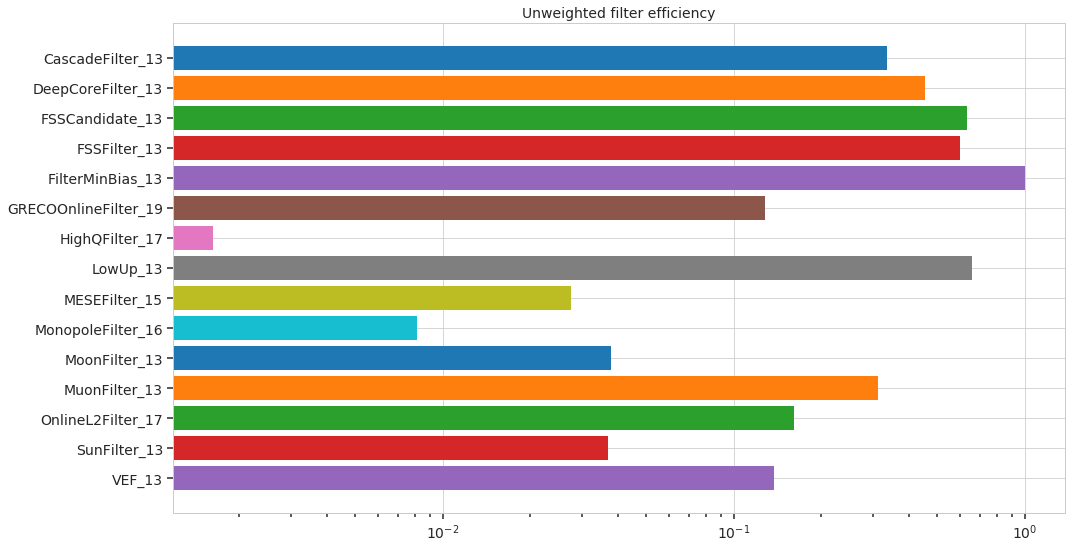

In [54]:
fig, ax = plt.subplots(figsize =(16, 9))
for ic_filter in filter_list:
    if bar_values[ic_filter]!=0:
        ax.barh(ic_filter, bar_values_unweighted[ic_filter]/len(data))
ax.set_xscale("log")
ax.invert_yaxis()
ax.set_title("Unweighted filter efficiency")